In [1]:
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from scvi_colab import install
install()
run_outside_colab=True
import scvi
import scipy.sparse
import decoupler as dc
import torch
import gzip
from gtfparse import read_gtf
from pybiomart import Dataset,Server
import os

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [2]:
############## Read in GENCODE for protein coding genes ################
gencode=read_gtf("../../gencode.v44.annotation.gtf")
protein_coding_genes = list(gencode.gene_name[np.where((gencode.feature=='gene')
            &(gencode.gene_type=='protein_coding')
            )[0]])


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [3]:
glia = sc.read('../../HIV_data/single_cell_scorch/glia_v2_updated.h5ad')
glia
#glia.var_names=glia.var_names.str.upper()
#glia.var['gene_ids'] = glia.var_names
#glia.var=glia.var.reset_index(drop=True)
#glia.var_names= glia.var.gene_ids
#glia_upd = sc.read('../../SCORCH_HIV_data/glia_updated.h5ad')

AnnData object with n_obs × n_vars = 223707 × 42748
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


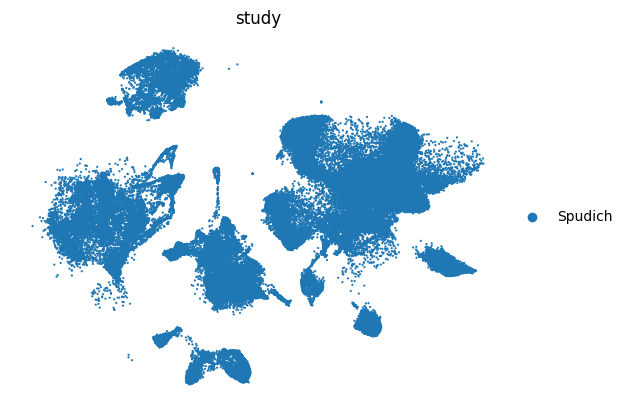

In [4]:
sc.pl.umap(
    glia[np.where((glia.obs.study=='Spudich'))[0]],
    color=["study"],
    frameon=False,
    size=10
)

In [5]:
glia = glia[:,np.where(glia.var.isin(protein_coding_genes))[0]]
glia

View of AnnData object with n_obs × n_vars = 223707 × 18231
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [6]:
sc.pp.filter_genes(glia, min_cells = 10)
glia

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 223707 × 18134
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [7]:
glia.var.gene_ids.is_unique

True

In [8]:
controls = list(np.where(
    (glia.obs['sample'].str.contains('HCCCY')) |
    (glia.obs['sample'].str.contains('HCCRS')) |
    (glia.obs['sample'].str.contains('HCTGD')) |
    (glia.obs['sample'].str.contains('HCTKN')) |
    (glia.obs['sample'].str.contains('HCTLI')) |
    (glia.obs['sample'].str.contains('HCTMU')) |
    (glia.obs['sample'].str.contains('HCTMW')) |
    (glia.obs['sample'].str.contains('HCTPK')) |
    (glia.obs['sample'].str.contains('HCTTS')) |
    (glia.obs['sample'].str.contains('HCTXJ')) |
    (glia.obs['sample'].str.contains('HCcPL')) |
    (glia.obs['sample'].str.contains('HCtME')) |
    (glia.obs['sample'].str.contains('HCtNZ'))
)[0])

# HIV samples excluding OUD
hiv = list(np.where(
    (glia.obs['sample'].str.contains('10280')) |
    (glia.obs['sample'].str.contains('10288')) |
    (glia.obs['sample'].str.contains('10304')) |
    (glia.obs['sample'].str.contains('10305')) |
    (glia.obs['sample'].str.contains('1068')) |
    (glia.obs['sample'].str.contains('1129')) |
    (glia.obs['sample'].str.contains('1137')) |
    (glia.obs['sample'].str.contains('6801066772')) |
    (glia.obs['sample'].str.contains('6801187468')) |
    (glia.obs['sample'].str.contains('7100518287')) |
    (glia.obs['sample'].str.contains('7101847783')) |
    (glia.obs['sample'].str.contains('7102096765')) |
    (glia.obs['sample'].str.contains('7200776574')) 
)[0])

# HIV samples with ART
hiv_art = list(np.where(
    (glia.obs['sample'].str.contains('010280')) |
    (glia.obs['sample'].str.contains('010288')) |
    (glia.obs['sample'].str.contains('010304')) |
    (glia.obs['sample'].str.contains('010305')) |
    (glia.obs['sample'].str.contains('1129')) |
    (glia.obs['sample'].str.contains('6801066772')) |
    (glia.obs['sample'].str.contains('6801187468')) |
    (glia.obs['sample'].str.contains('7102096765')) |
    (glia.obs['sample'].str.contains('7201068268'))
)[0])

# HIV samples with no ART
hiv_no_art = list(np.where(
    (glia.obs['sample'].str.contains('1068')) |
    (glia.obs['sample'].str.contains('7100518287')) |
    (glia.obs['sample'].str.contains('7101847783')) |
    (glia.obs['sample'].str.contains('7200776574'))
)[0])

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


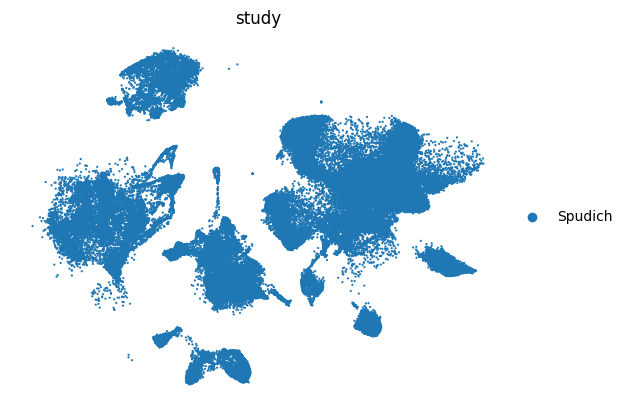

In [9]:
sc.pl.umap(
    glia[np.where((glia.obs.study=='Spudich'))[0]],
    color=["study"],
    frameon=False,
    size=10
)

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


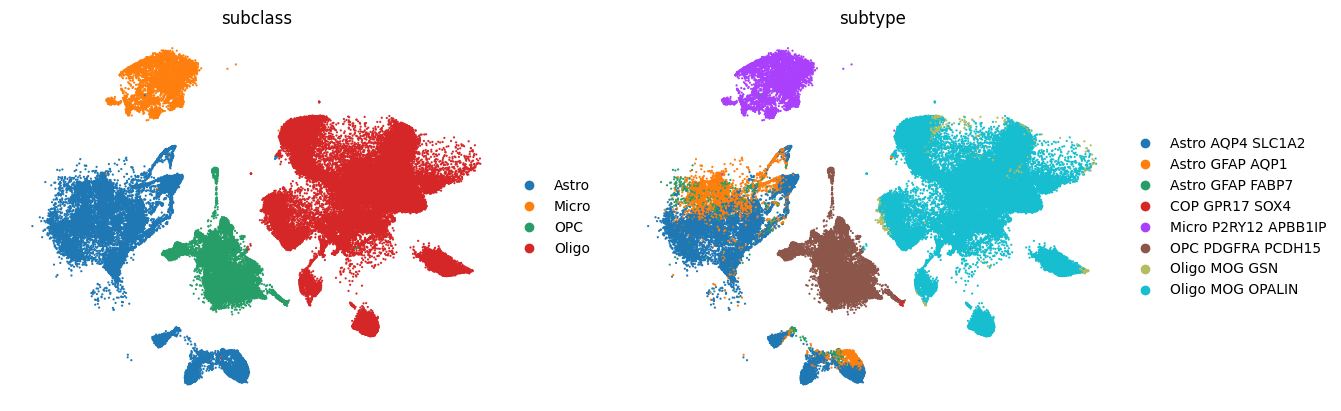

In [10]:
sc.pl.umap(
    glia[np.where((glia.obs.study=='Spudich'))[0]],
    color=["subclass","subtype"],
    frameon=False,
    size=10
)

In [17]:
pd.unique(glia.obs.iloc[np.where(glia.obs['subclass']=='Micro')[0],:]['subtype'])

['Micro P2RY12 APBB1IP', 'Astro GFAP FABP7']
Categories (9, object): ['Astro AQP4 SLC1A2', 'Astro GFAP AQP1', 'Astro GFAP FABP7', 'COP GPR17 SOX4', ..., 'OPC PDGFRA PCDH15', 'Oligo MOG FRY', 'Oligo MOG GSN', 'Oligo MOG OPALIN']

In [23]:
glia[np.where((glia.obs['subclass']=='Micro')&(glia.obs['subtype']=='Astro GFAP FABP7'))[0]].obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,study,...,class,TopSubclassScore,TopClassScore,TopSubtypeScore,integrated_snn_res.0.5,ident,n_genes,_scvi_batch,_scvi_labels,doublet
10304_HIV_PFC_TTGTGAGGTTTATCTG-1,SeuratProject,2938.0,1774,10304_HIV_PFC,0.068074,3357.0,1771,16,12,Spudich,...,Glia,0.58027,0.61609,0.449336,12,12,1774,0,0,singlet


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 300/300: 100%|███████████████████████████████████████████████████████████| 300/300 [54:55:20<00:00, 314.12s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.01e+3]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|███████████████████████████████████████████████████████████| 300/300 [54:55:20<00:00, 659.07s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.01e+3]


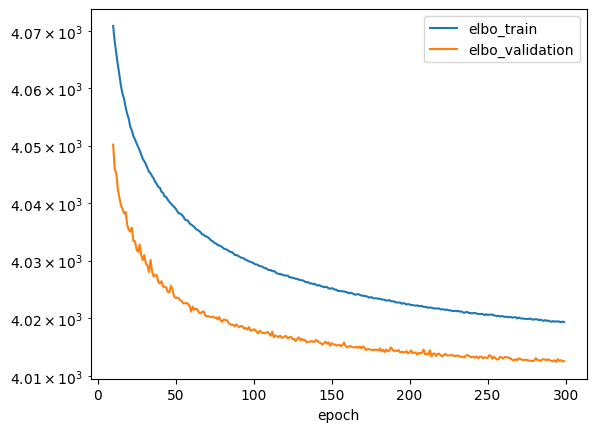

DE...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:47<00:00, 347.77s/it]
Astro
Num Genes:16050
Num cells:15001


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|█████████████████████████████████████████████████████████████| 200/200 [1:02:42<00:00, 18.82s/it, v_num=1, train_loss_step=5.67e+3, train_loss_epoch=5.23e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█████████████████████████████████████████████████████████████| 200/200 [1:02:42<00:00, 18.81s/it, v_num=1, train_loss_step=5.67e+3, train_loss_epoch=5.23e+3]


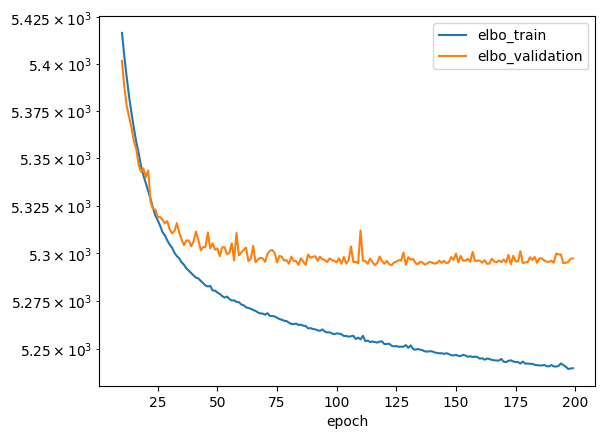

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.62s/it]
OPC
Num Genes:15006
Num cells:10783


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [30:14<00:00,  9.08s/it, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.48e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [30:14<00:00,  9.07s/it, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.48e+3]


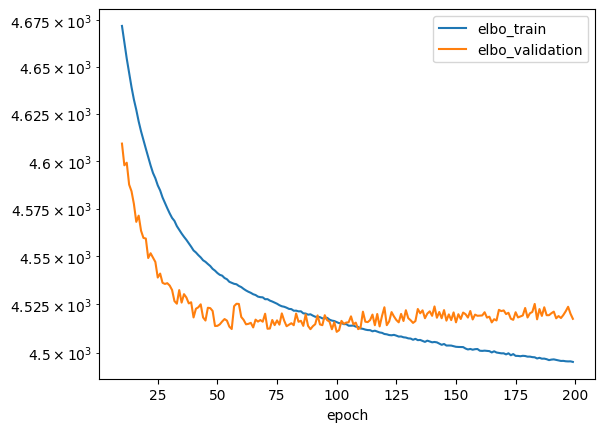

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.41s/it]
Oligo
Num Genes:16422
Num cells:55603


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|████████████████████████████████████████████████████████████| 200/200 [9:42:07<00:00, 151.44s/it, v_num=1, train_loss_step=3.74e+3, train_loss_epoch=3.63e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████████████████████████████████████████████████████████████| 200/200 [9:42:08<00:00, 174.64s/it, v_num=1, train_loss_step=3.74e+3, train_loss_epoch=3.63e+3]


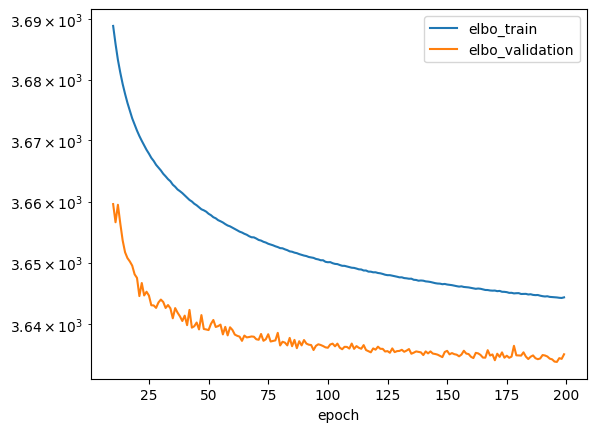

DE...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:17<00:00, 137.59s/it]
Micro
Num Genes:13835
Num cells:6444


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 149/200:  74%|██████████████████████████████████████████████▉                | 149/200 [07:04<02:25,  2.85s/it, v_num=1, train_loss_step=3.14e+3, train_loss_epoch=3.12e+3]
Monitored metric elbo_validation did not improve in the last 100 records. Best score: 3255.088. Signaling Trainer to stop.


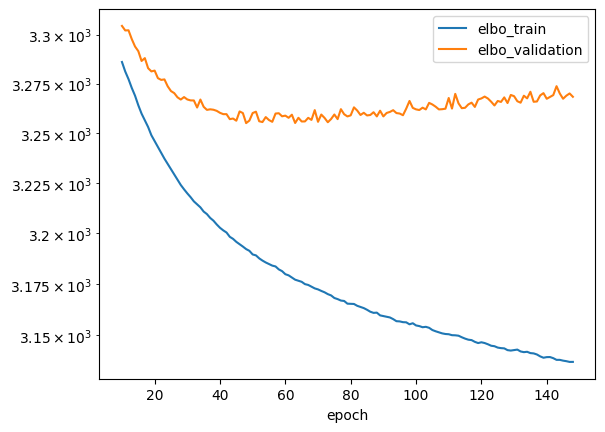

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.05s/it]


In [10]:
##################################################Parameters:##################################
adata_ref_disease = glia[hiv+controls].copy()
results_dir = '../../results/SCORCH_HIV/diff_exp/glia/hiv_pos_VS_ctrl/'
cond1 = 'hiv'
cond2 = 'controls'
adata_ref_disease.obs['condition'] = np.where(((adata_ref_disease.obs['sample'].str.contains('HCCCY')) |
    (adata_ref_disease.obs['sample'].str.contains('HCCRS')) | (adata_ref_disease.obs['sample'].str.contains('HCTGD')) | 
    (adata_ref_disease.obs['sample'].str.contains('HCTKN')) | (adata_ref_disease.obs['sample'].str.contains('HCTLI')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTMU')) | (adata_ref_disease.obs['sample'].str.contains('HCTMW')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTPK')) | (adata_ref_disease.obs['sample'].str.contains('HCTTS')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTXJ')) | (adata_ref_disease.obs['sample'].str.contains('HCcPL')) |
    (adata_ref_disease.obs['sample'].str.contains('HCtME')) | (adata_ref_disease.obs['sample'].str.contains('HCtNZ'))
                                         ),cond2,cond1)
#adata_ref_disease.obs['condition'] = np.where(( (adata_ref_disease.obs['sample'].str.contains('1068')) |
 #                                              (adata_ref_disease.obs['sample'].str.contains('7100518287')) | 
  #                                             (adata_ref_disease.obs['sample'].str.contains('7101847783')) |
   #                                            (adata_ref_disease.obs['sample'].str.contains('7200776574'))
    #),'hiv_no_art','hiv_art')
###############################################################################################
#sc.pp.filter_genes(adata_ref_disease, min_cells = 10)
#sc.pp.highly_variable_genes(
 #       adata_ref_disease,
  #      n_top_genes=10000,
   #     subset=True,
    #    flavor="seurat_v3"
     #   )
scvi.model.SCVI.setup_anndata(adata_ref_disease, #layer="UMIs",
                              categorical_covariate_keys=['sample','sex'],
                              continuous_covariate_keys=["age_value"]
                             )
model = scvi.model.SCVI(
    adata_ref_disease, gene_likelihood="nb"
    )  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=300,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    )
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

de_change = model.differential_expression(idx1=adata_ref_disease.obs['condition']==cond1,
                                          idx2=adata_ref_disease.obs['condition']==cond2, weights='uniform')

#de = de_change.loc[de_change['is_de_fdr_0.05']==True,:]
de_change["log10_pscore"] = (-1)*np.log10(de_change["proba_not_de"])
de_change.to_csv(results_dir+'allcells_protein_coding.tsv',sep='\t')
#de_change.to_csv(results_dir+'_allcells.tsv',sep='\t')

for cell_type in pd.unique(adata_ref_disease.obs.subclass):
    print(cell_type)
    cells = list(np.where(adata_ref_disease.obs.subclass==cell_type)[0])
    adata_cell = adata_ref_disease[cells].copy()
    sc.pp.filter_genes(adata_cell, min_cells = 10)
    #sc.pp.highly_variable_genes(
     #   adata_cell,
      #  n_top_genes=5000,
       # subset=True,
        #flavor="seurat_v3"
        #)
    print("Num Genes:"+str(len(adata_cell.var)))
    print('Num cells:'+str(len(adata_cell.obs)))
    ####################################Skip the cell type with fewer than 10 cells in each condition#######################
    if (len(np.where(adata_cell.obs['condition']==cond1)[0])<10) or (len(np.where(adata_cell.obs['condition']==cond2)[0])<10):
        continue
    #########################################################################################################################
    scvi.model.SCVI.setup_anndata(adata_cell, #layer="UMIs",
                                  categorical_covariate_keys=['sample','sex'],
                                  continuous_covariate_keys=["age_value"]
                                 )
    model = scvi.model.SCVI(
        adata_cell, gene_likelihood="nb")  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
    model.train(
        check_val_every_n_epoch=1,
        max_epochs=200,
        early_stopping=True,
        early_stopping_patience=100,
        early_stopping_monitor="elbo_validation",
        batch_size=103,
        plan_kwargs={"lr": 0.001}
        )
    train_test_results = model.history["elbo_train"]
    train_test_results["elbo_validation"] = model.history["elbo_validation"]
    train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
    plt.show()
    de_change = model.differential_expression(idx1=adata_cell.obs['condition']==cond1,
                                       idx2=adata_cell.obs['condition']==cond2, weights="uniform")
    
    #de_change = de_change.loc[de['is_de_fdr_0.05']==True,:]
    de_change.loc[:,"log10_pscore"] = (-1)*np.log10(de_change["proba_not_de"])
    cell_type = cell_type.replace('/','')
    cell_type = cell_type.replace(" ","")
    de_change.to_csv(results_dir+cell_type+'_protein_coding.tsv',sep='\t')

## GSEA

In [11]:
gene_sets_to_test = ['GO_Biological_Process_2023','GO_Cellular_Component_2023','GO_Molecular_Function_2023',
                    'WikiPathway_2023_Human',
                    'MSigDB_Hallmark_2020',
                    'KEGG_2021_Human']

In [14]:
file_path_diff_exp = '../../results/SCORCH_HIV/diff_exp/glia/hiv_pos_VS_ctrl/'
file_path_gmt = '../../gene_sets/'
gsea_on = 'all_de_genes/'#'all_de_genes' or 'positive_regulated' or 'negative_regulated'
results_dir = '../../results/SCORCH_HIV/gsea/glia/'+gsea_on+'hiv_pos_VS_ctrl/'#Make sure correct DEG data frame is read as 'input_gsea'

for file in os.listdir(file_path_diff_exp):
    if 'tsv' in file:
        diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
        diff_exp.loc[:,'sign_lfc']=np.where(diff_exp['lfc_median']<0,-1,1)
        file = file.replace(" ","")
        cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
        print(cell_type)
        
        ######################## For all DEGs or separate +ve and -ve regulated genes############################
        col = np.where(diff_exp.columns=='log10_pscore')[0]
        diff_exp.loc[:,'metric_gsea'] = diff_exp['log10_pscore']*diff_exp['sign_lfc']
        input_gsea = pd.DataFrame(columns=['metric_gsea'])
        
        if gsea_on=='all_de_genes/':
            input_gsea = diff_exp.loc[:,'metric_gsea']
        #Positive DEGs:
        elif gsea_on=='upreg_genes/':
            input_gsea = diff_exp.iloc[list(np.where(diff_exp['lfc_median']>0)[0]),'metric_gsea']        
        #Negative DEGs
        elif gsea_on=='downreg_genes/':
            input_gsea = diff_exp.iloc[np.where(diff_exp.lfc_median<0)[0],'metric_gsea']

        input_gsea = input_gsea.sort_values(ascending=False)
        gsea_all_paths = pd.DataFrame()
        
        ## Exception handling for when the gmt gene set is irrelevant for the differentially expressed genes
        try:
            gsea_result = gseapy.prerank(rnk=input_gsea, gene_sets=gene_sets_to_test, organism='human')
        except LookupError:
            continue
        #filtered_sets = gsea_result.res2d.iloc[
                                            #np.where((gsea_result.res2d['NOM p-val']<=0.05)&
                                                    #(gsea_result.res2d['FDR q-val']<=0.25))[0]
                                            #,:]
        filtered_sets = gsea_result.res2d
        if len(filtered_sets)>0:
            gsea_all_paths = pd.concat([gsea_all_paths,filtered_sets]).reset_index(drop=True)
            gsea_all_paths=gsea_all_paths.drop_duplicates()
            gsea_all_paths.to_csv(results_dir+cell_type+'.tsv', sep='\t',index=False)

2024-06-08 21:38:33,557 [WARNING] Duplicated values found in preranked stats: 72.48% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Oligo


2024-06-08 21:47:05,390 [WARNING] Duplicated values found in preranked stats: 74.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


OPC


2024-06-08 21:54:32,113 [WARNING] Duplicated values found in preranked stats: 77.83% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


allcells


2024-06-08 22:04:25,034 [WARNING] Duplicated values found in preranked stats: 77.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Micro


2024-06-08 22:10:59,675 [WARNING] Duplicated values found in preranked stats: 75.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Astro


In [1]:
def get_all_DEG(file_path_diff_exp):
    all_DEG = pd.DataFrame()
    for file in os.listdir(file_path_diff_exp):
        if 'tsv' in file and 'lfc' not in file and 'allcells' not in file:
            diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
            file = file.replace(" ","")
            cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
            diff_exp.loc[:,'cell_type'] = cell_type
            diff_exp = diff_exp.reset_index().rename(columns={"index":'gene'})
        
            ######For numerical stability: replace infinite values with twice of maximum
            max_twice = diff_exp.loc[diff_exp['log10_pscore'] != np.inf, 'log10_pscore'].max()*2
            diff_exp['log10_pscore'].replace(np.inf,max_twice,inplace=True)
                
            #volcano(diff_exp,cell_type, file_path_diff_exp)
            all_DEG = pd.concat([all_DEG,diff_exp]) #Read in and saved in a previous run is used further in the volcano plot function
    all_DEG = all_DEG.reset_index(drop=True)
    return all_DEG

In [3]:
def get_selection_metric(df):
    selection_metric = df['bayes_factor'] * abs(df['lfc_median'])
    df.loc[:,'selection_metric'] = selection_metric
    return df

In [4]:
all_deg_glia = get_all_DEG('../../results/SCORCH_HIV/diff_exp/glia/hiv_pos_VS_ctrl/')
all_deg_glia = get_selection_metric(all_deg_glia)
all_deg_glia

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
0,CRH,0.9746,0.0254,3.647278,4.213108e-07,0.000004,0.0,0.25,-3.603700,-3.660887,...,0.000203,0.006789,0.000203,0.006539,0.001318,0.039974,True,1.595166,Oligo,13.352270
1,FKBP5,0.9740,0.0260,3.623314,4.323445e-04,0.000055,0.0,0.25,2.899302,2.882069,...,1.083448,0.086983,0.456852,0.068312,4.173294,0.459121,True,1.585027,Oligo,10.442642
2,SST,0.9700,0.0300,3.476098,2.474980e-06,0.000020,0.0,0.25,-3.565309,-3.653357,...,0.003458,0.036730,0.002848,0.033474,0.018399,0.215563,True,1.522879,Oligo,12.699430
3,TTC9B,0.9686,0.0314,3.429044,2.712594e-06,0.000017,0.0,0.25,-3.101162,-3.096312,...,0.004729,0.034031,0.004678,0.032306,0.024537,0.195951,True,1.503070,Oligo,10.617387
4,CCK,0.9630,0.0370,3.259135,2.023307e-05,0.000113,0.0,0.25,-3.072930,-3.059304,...,0.032393,0.207357,0.030359,0.161918,0.178929,1.170199,True,1.431798,Oligo,9.970686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,TTBK2,0.3486,0.6514,-0.625199,1.715698e-04,0.000171,0.0,0.25,0.000193,0.003487,...,0.960188,0.395059,0.507184,0.297048,1.837411,1.776598,False,0.186152,Astro,-0.002180
61309,BRAF,0.3416,0.6584,-0.656172,3.304985e-04,0.000337,0.0,0.25,-0.027146,-0.005321,...,1.834963,0.721832,0.700359,0.464953,3.443162,3.224423,False,0.181510,Astro,-0.003491
61310,PTBP2,0.3394,0.6606,-0.665969,2.646448e-04,0.000259,0.0,0.25,0.015765,0.008039,...,1.455598,0.618196,0.636101,0.421370,2.748101,2.765552,False,0.180061,Astro,-0.005353
61311,NSMCE2,0.2960,0.7040,-0.866419,2.655513e-04,0.000270,0.0,0.25,-0.021205,-0.019424,...,1.544303,0.627837,0.632608,0.413336,2.987815,2.826657,False,0.152427,Astro,-0.016830


In [7]:
all_deg_glia.iloc[np.where((all_deg_glia.gene_ids=='NR3C1')#&(all_deg_glia['is_de_fdr_0.05']==True)
                          )[0],:]

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
13109,NR3C1,0.6708,0.3292,0.711806,0.000282,0.000356,0.0,0.25,-0.335298,-0.345718,...,0.839664,0.659664,0.439156,0.420112,2.851409,3.599949,False,0.482540,Oligo,0.246084
28918,NR3C1,0.7038,0.2962,0.865459,0.000219,0.000282,0.0,0.25,-0.388267,-0.371747,...,0.915477,0.798526,0.480684,0.498157,2.344279,3.135688,False,0.528415,OPC,0.321732
42292,NR3C1,0.8068,0.1932,1.429350,0.000338,0.000509,0.0,0.25,-0.599799,-0.620461,...,0.547965,0.673114,0.362124,0.441006,3.450686,5.085219,False,0.713993,Micro,0.886856
59728,NR3C1,0.6604,0.3396,0.665077,0.000124,0.000140,0.0,0.25,-0.175335,-0.202583,...,0.707444,0.317534,0.386749,0.244025,1.323743,1.467710,False,0.469032,Astro,0.134733


## Create pseudobulks

In [8]:
pseudobulk_adata = dc.get_pseudobulk(
    glia[controls+hiv],
    sample_col='sample',
    groups_col='subclass',
    #layer='UMIs',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pseudobulk_adata

AnnData object with n_obs × n_vars = 104 × 18115
    obs: 'orig.ident', 'sample', 'study', 'subclass', 'class', '_scvi_batch', '_scvi_labels', 'doublet', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'psbulk_props'

In [12]:
pseudobulk_adata.obs

,orig.ident,sample,study,subclass,class,_scvi_batch,_scvi_labels,doublet,psbulk_n_cells,psbulk_counts
10280_HIV_PFC_Astro,SeuratProject,10280_HIV_PFC,Spudich,Astro,Glia,0,0,singlet,325.0,715490.0
10288_HIV_PFC_Astro,SeuratProject,10288_HIV_PFC,Spudich,Astro,Glia,0,0,singlet,1421.0,6636863.0
10304_HIV_PFC_Astro,SeuratProject,10304_HIV_PFC,Spudich,Astro,Glia,0,0,singlet,958.0,3884175.0
10305_HIV_PFC_Astro,SeuratProject,10305_HIV_PFC,Spudich,Astro,Glia,0,0,singlet,602.0,3822648.0
1068_HIV_PFC_Astro,SeuratProject,1068_HIV_PFC,Spudich,Astro,Glia,0,0,singlet,389.0,1703624.0
...,...,...,...,...,...,...,...,...,...,...
HCTTS_CTR_PFC_MAH_Oligo,SeuratProject,HCTTS_CTR_PFC_MAH,Spudich,Oligo,Glia,0,0,singlet,767.0,1298514.0
HCTXJ_CTR_PFC_Oligo,SeuratProject,HCTXJ_CTR_PFC,Spudich,Oligo,Glia,0,0,singlet,2310.0,3150410.0
HCcPL_CTR_PFC_MAH_Oligo,SeuratProject,HCcPL_CTR_PFC_MAH,Spudich,Oligo,Glia,0,0,singlet,421.0,1005868.0
HCtME_CTR_PFC_MAH_Oligo,SeuratProject,HCtME_CTR_PFC_MAH,Spudich,Oligo,Glia,0,0,singlet,4718.0,10380317.0


In [13]:
pbulk_controls = list(np.where(
(pseudobulk_adata.obs['sample'].str.contains('CTR'))
)[0])


################ HIV samples ####################
pbulk_hiv = list(np.where(
(pseudobulk_adata.obs['sample'].str.contains('HIV'))
)[0])

In [14]:
pd.DataFrame(data=pseudobulk_adata.X[pbulk_controls],
             columns=pseudobulk_adata.var.iloc[:,0],
             index=pseudobulk_adata.obs.index[pbulk_controls]).T.to_csv('../../HIV_data/single_cell_scorch/glia_v2_pbulk_controls.tsv',sep='\t')

pd.DataFrame(data=pseudobulk_adata.X[pbulk_hiv],
             columns=pseudobulk_adata.var.iloc[:,0],
             index=pseudobulk_adata.obs.index[pbulk_hiv]).T.to_csv('../../HIV_data/single_cell_scorch/glia_v2_pbulk_hiv.tsv',sep='\t')


# Kellis OUD samples

In [8]:
# Healthy control samples from Kellis study
controls_oud = list(np.where(
    (glia.obs['sample'].str.contains('HCtDL')) |
    (glia.obs['sample'].str.contains('HCtIU')) |
    (glia.obs['sample'].str.contains('HCtPA')) |
    (glia.obs['sample'].str.contains('HCtRP')) |
    (glia.obs['sample'].str.contains('HCtQQ')) |
    (glia.obs['sample'].str.contains('HCtVE')) |
    (glia.obs['sample'].str.contains('HCtVF')) |
    (glia.obs['sample'].str.contains('HCtWL')) |
    (glia.obs['sample'].str.contains('HCtDI'))
)[0])

# OUD samples
oud = list(np.where(
    (glia.obs['sample'].str.contains('HCcLS')) |
    (glia.obs['sample'].str.contains('HCcPN')) |
    (glia.obs['sample'].str.contains('HCcOV')) |
    (glia.obs['sample'].str.contains('HCcHO')) |
    (glia.obs['sample'].str.contains('HCcOE')) |
    (glia.obs['sample'].str.contains('HCcFW')) |
    (glia.obs['sample'].str.contains('NIH1308')) |
    (glia.obs['sample'].str.contains('HCCWQ')) |
    (glia.obs['sample'].str.contains('HccUD')) |
    (glia.obs['sample'].str.contains('HCcWK'))
)[0])

In [9]:
pseudobulk_adata_oud = dc.get_pseudobulk(
    glia[oud+controls_oud],
    sample_col='sample',
    groups_col='subclass',
    #layer='UMIs',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pseudobulk_adata_oud

AnnData object with n_obs × n_vars = 75 × 18085
    obs: 'orig.ident', 'sample', 'study', 'subclass', 'class', '_scvi_batch', '_scvi_labels', 'doublet', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'psbulk_props'

In [10]:
pseudobulk_adata_oud.obs

,orig.ident,sample,study,subclass,class,_scvi_batch,_scvi_labels,doublet,psbulk_n_cells,psbulk_counts
HCCWQ_09_BA9-FC_Astro,SeuratProject,HCCWQ_09_BA9-FC,Kellis,Astro,Glia,0,0,singlet,934.0,6600180.0
HCcFW_07_BA9-FC_Astro,SeuratProject,HCcFW_07_BA9-FC,Kellis,Astro,Glia,0,0,singlet,514.0,1683386.0
HCcHO_05_BA9-FC_Astro,SeuratProject,HCcHO_05_BA9-FC,Kellis,Astro,Glia,0,0,singlet,205.0,996010.0
HCcLS_01_BA9-FC_Astro,SeuratProject,HCcLS_01_BA9-FC,Kellis,Astro,Glia,0,0,singlet,142.0,171883.0
HCcOE_06_BA9-FC_Astro,SeuratProject,HCcOE_06_BA9-FC,Kellis,Astro,Glia,0,0,singlet,572.0,4400630.0
...,...,...,...,...,...,...,...,...,...,...
HCtVE_20_BA9-FC_Oligo,SeuratProject,HCtVE_20_BA9-FC,Kellis,Oligo,Glia,0,0,singlet,3544.0,16001104.0
HCtVF_21_BA9-FC_Oligo,SeuratProject,HCtVF_21_BA9-FC,Kellis,Oligo,Glia,0,0,singlet,1540.0,4961122.0
HCtWL_22_BA9-FC_Oligo,SeuratProject,HCtWL_22_BA9-FC,Kellis,Oligo,Glia,0,0,singlet,767.0,2757450.0
HccUD_10_BA9-FC_Oligo,SeuratProject,HccUD_10_BA9-FC,Kellis,Oligo,Glia,0,0,singlet,640.0,2453983.0


In [11]:
pbulk_controls_oud = list(np.where(
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtDL')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtIU')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtPA')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtRP')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtQQ')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtVE')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtVF')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtWL')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCtDI'))
)[0])


################ OUD samples ####################
pbulk_oud = list(np.where(
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcLS')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcPN')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcOV')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcHO')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcOE')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcFW')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('NIH1308')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCCWQ')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HccUD')) |
    (pseudobulk_adata_oud.obs['sample'].str.contains('HCcWK'))
)[0])

In [12]:
pd.DataFrame(data=pseudobulk_adata_oud.X[pbulk_controls_oud],
             columns=pseudobulk_adata_oud.var.iloc[:,0],
             index=pseudobulk_adata_oud.obs.index[pbulk_controls_oud]).T.to_csv('../../HIV_data/single_cell_scorch/glia_v2_pbulk_controls_oud.tsv',sep='\t')

pd.DataFrame(data=pseudobulk_adata_oud.X[pbulk_oud],
             columns=pseudobulk_adata_oud.var.iloc[:,0],
             index=pseudobulk_adata_oud.obs.index[pbulk_oud]).T.to_csv('../../HIV_data/single_cell_scorch/glia_v2_pbulk_oud.tsv',sep='\t')
